In [2]:
from topact.countdata import CountMatrix
from topact.classifier import SVCClassifier, train_from_countmatrix

In [4]:
import scanpy as sc
import squidpy as sq

In [6]:
scdata = sc.read_h5ad("./RNA/sc.B03903E6.h5")

In [7]:
def extract_guide_from_rna(cdata):
    sg_genes = cdata.var_names[cdata.var_names.str.startswith("sg")]
    rna_genes = cdata.var_names[~cdata.var_names.str.startswith("sg")]
    guidedata = cdata[:, sg_genes]
    rnadata = cdata[:, rna_genes]
    return rnadata, guidedata

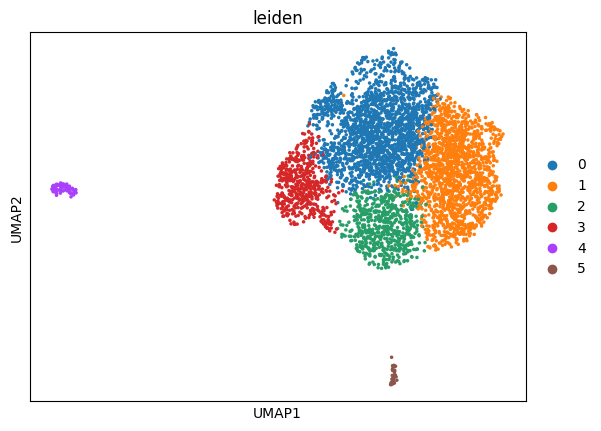

In [36]:
sc.pp.pca(scdata)
sc.pp.neighbors(scdata)
sc.tl.umap(scdata)
sc.tl.leiden(scdata, resolution=0.25)
sc.pl.umap(scdata, color='leiden')

In [39]:
scdata_clean = scdata[~scdata.obs["leiden"].isin(['4', '5'])].copy()

In [46]:
import pandas as pd
T_marker = {
    "memory T": ["Il7r", "Cd27", "Timp1"],
    "effector T": ["Gzmk", "Gzma", "Gzmb", "Prf1", "Nkg7"],
    "exhausted T": ["Havcr2", "Lag3", "Entpd1", "Tigit", "Ctla4", "Layn"],
    "stem-like T": ["Tcf7", "Foxo1"]
}
t_marker_list = []
for t_type in T_marker:
    t_marker_list += (T_marker[t_type])
t_marker_list

['Il7r',
 'Cd27',
 'Timp1',
 'Gzmk',
 'Gzma',
 'Gzmb',
 'Prf1',
 'Nkg7',
 'Havcr2',
 'Lag3',
 'Entpd1',
 'Tigit',
 'Ctla4',
 'Layn',
 'Tcf7',
 'Foxo1']

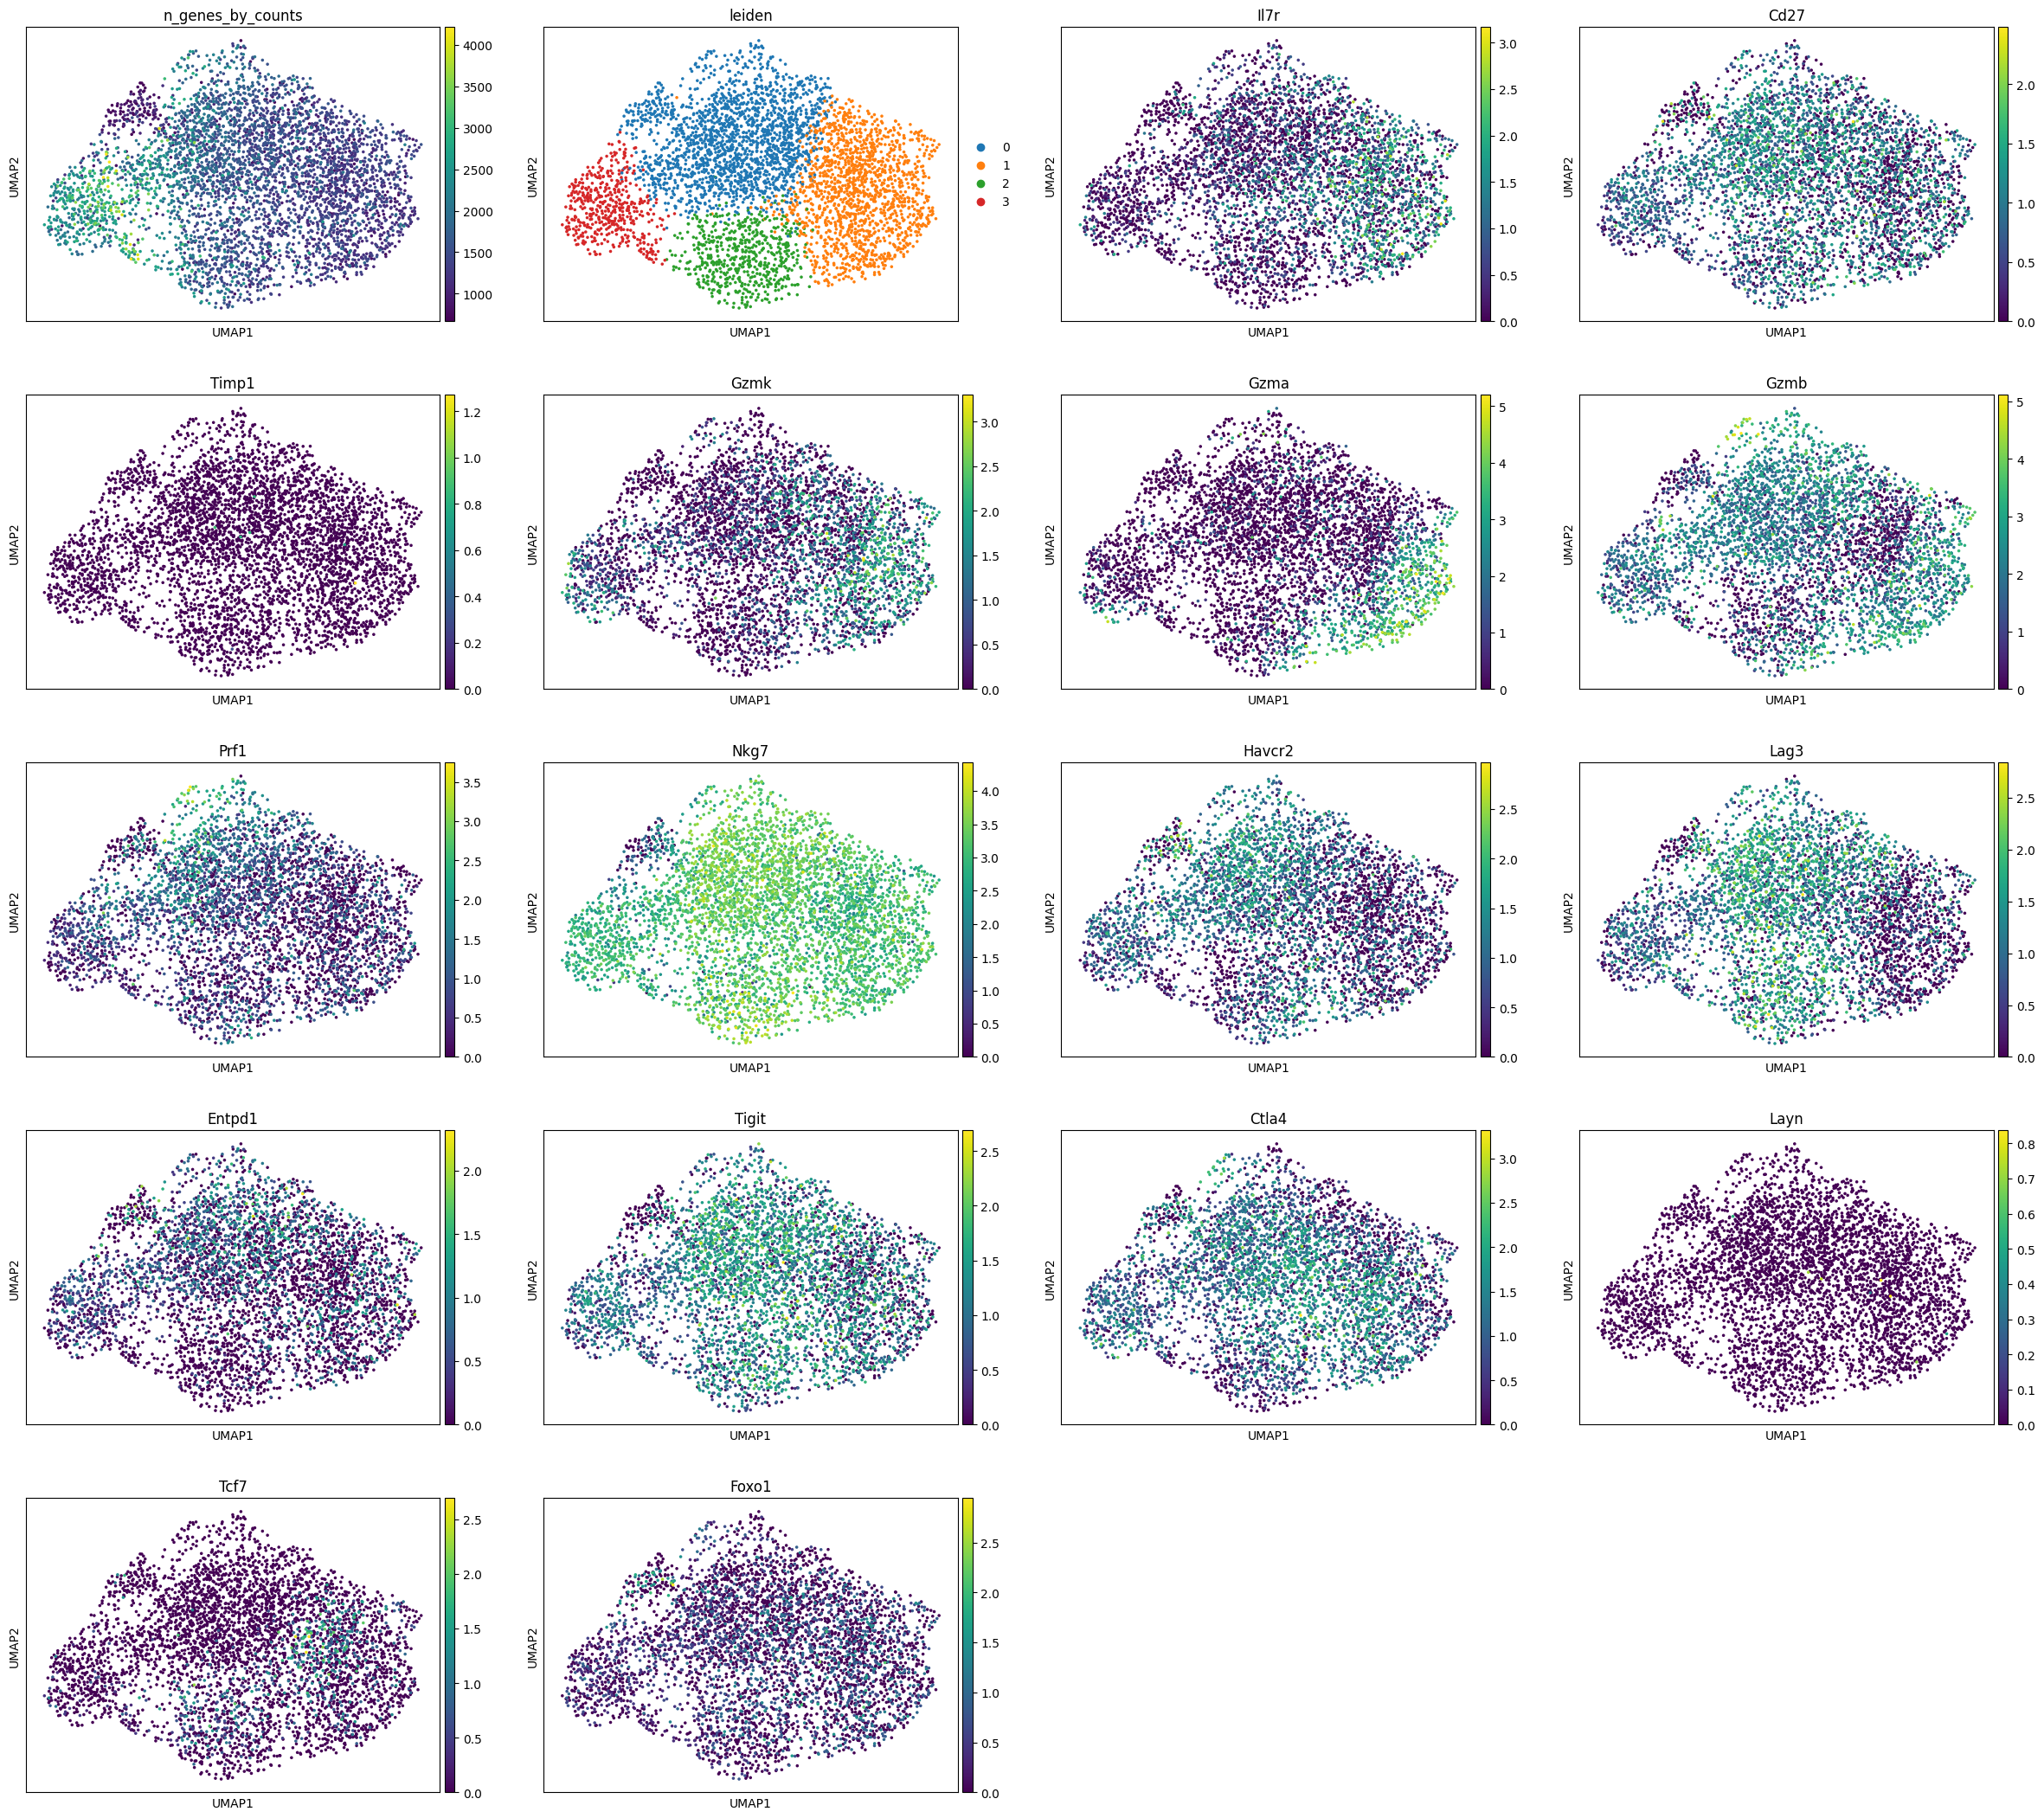

In [49]:
sc.pl.umap(scdata_clean, color=['n_genes_by_counts', 'leiden'] + t_marker_list)

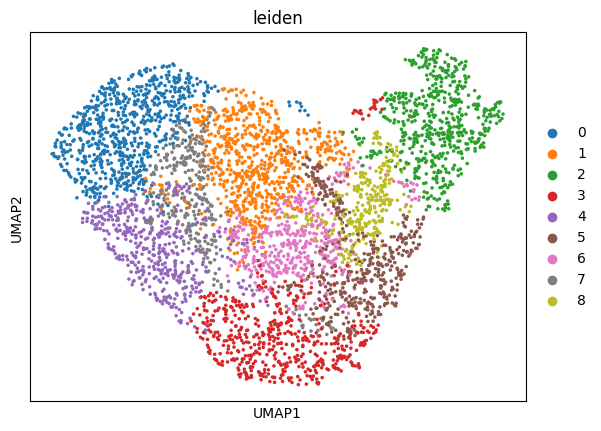

In [52]:
sc.pp.pca(scdata_clean)
sc.pp.neighbors(scdata_clean, n_neighbors=5, n_pcs=5)
sc.tl.umap(scdata_clean)
sc.tl.leiden(scdata_clean, resolution=0.25)
sc.pl.umap(scdata_clean, color='leiden')

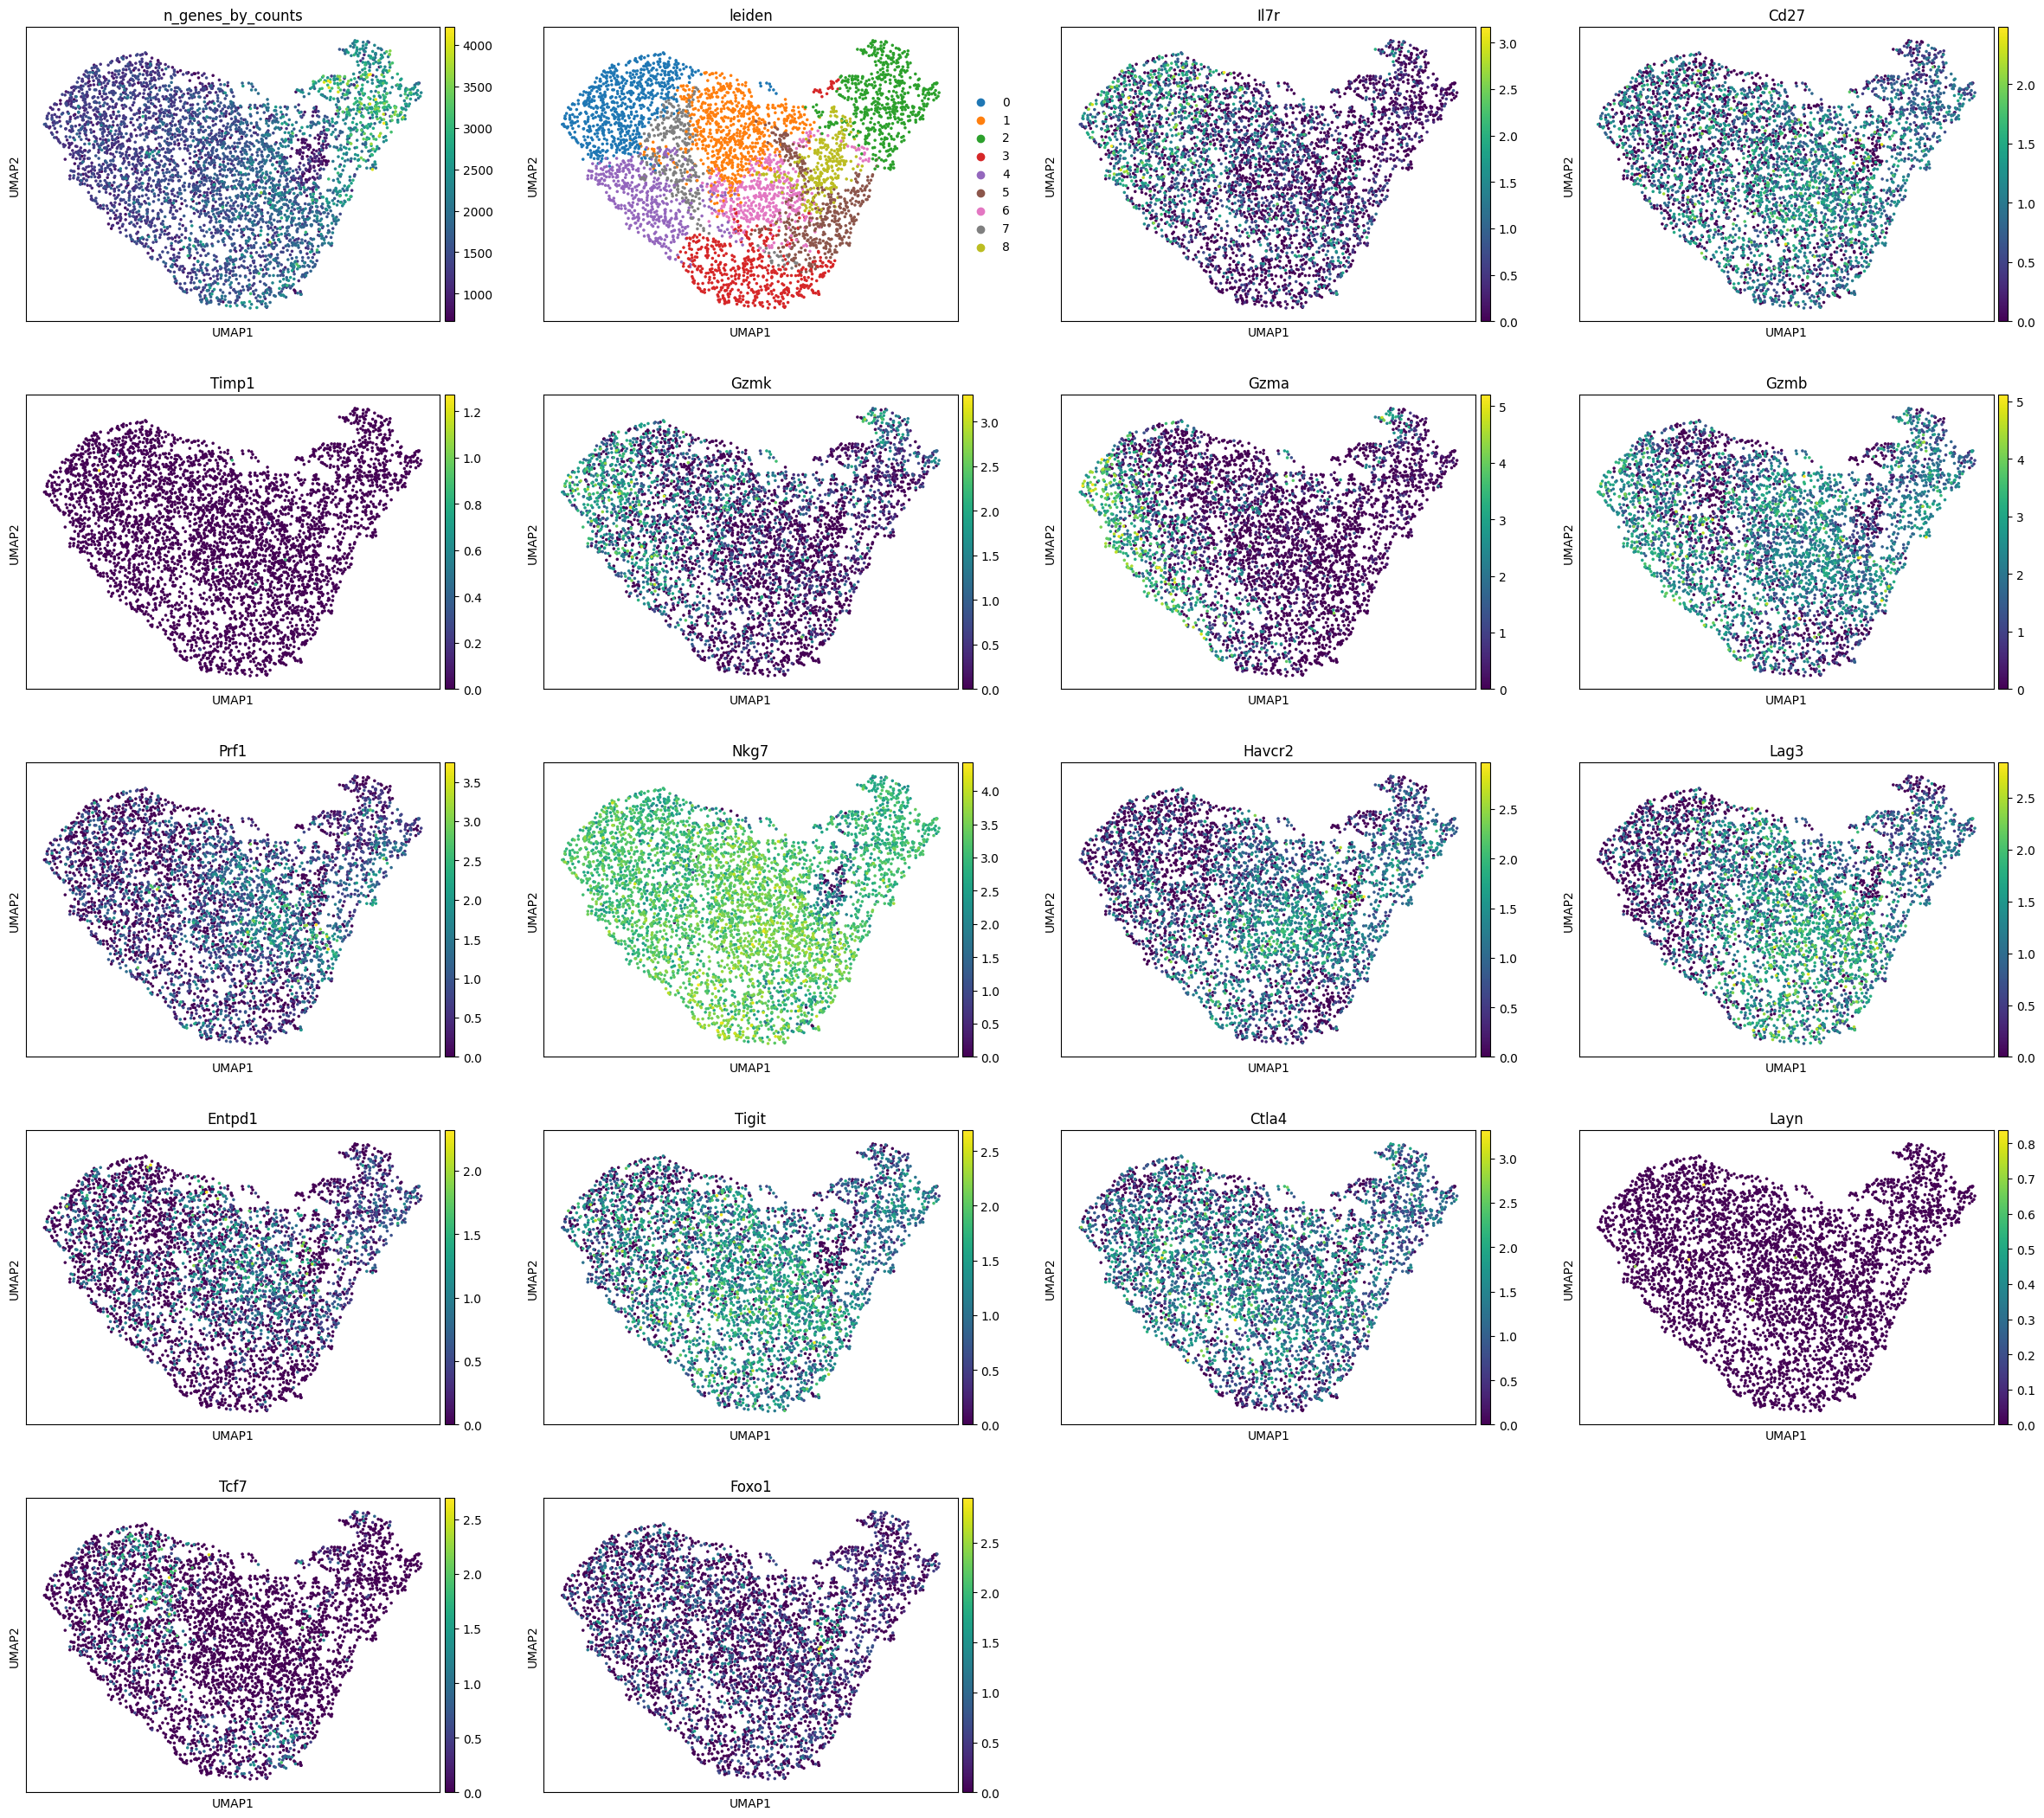

In [53]:
sc.pl.umap(scdata_clean, color=['n_genes_by_counts', 'leiden'] + t_marker_list)

In [56]:
for t_type in T_marker:
    sc.tl.score_genes(scdata_clean, gene_list=T_marker[t_type], score_name=t_type + "_score")

In [83]:
import numpy as np
name_dict = pd.DataFrame(scdata_clean.obs.columns[scdata_clean.obs.columns.str.endswith("T_score")])[0].str.rstrip('_score').to_dict()
scdata_clean.obs["t_type"] = pd.DataFrame(np.array(scdata_clean.obs.loc[:,scdata_clean.obs.columns.str.endswith("T_score")]).argmax(axis=1))[0].map(name_dict).tolist()

In [8]:
# fdata = sc.read_h5ad("./RNA/spatial.combined.bin20.h5")
# fdata_1, _ = extract_guide_from_rna(fdata)
# fdata_1 = fdata_1[fdata_1.obs["marker"] == "B"].copy()

In [84]:
fdata = sc.read_h5ad("./RNA/spatial.combined.annotation.h5")
fdata_1, _ = extract_guide_from_rna(fdata)
fdata_1 = fdata_1[fdata_1.obs["marker"] == "B"].copy()

In [85]:
fdata_t = fdata_1[fdata_1.obs["annotations"].str.endswith("T")].copy()

In [90]:
svc = CountMatrix(scdata_clean.X, genes=scdata_clean.var_names.tolist())
svc.add_metadata("celltype", scdata_clean.obs["t_type"].tolist())

In [91]:
clf = SVCClassifier()
train_from_countmatrix(clf, svc, 'celltype')

In [92]:
from topact import spatial

In [101]:
xdf = pd.DataFrame(fdata_t.X.toarray(), columns=fdata_t.var_names)
xdf = xdf.melt()
xdf.columns = ["gene", "counts"]

In [115]:
df = pd.concat([pd.DataFrame(fdata_t.obsm["spatial"])] * len(fdata_t.var_names))
df['index'] = (range(0, len(fdata_t.var_names) * len(fdata_t.obs_names)))
df.set_index('index', inplace=True)
df = pd.concat([df, xdf], axis=1)
df.columns = ["x", "y", "gene", "counts"]

In [118]:
sd = spatial.CountGrid.from_coord_table(df,
    genes=fdata_t.var_names,
    count_col="counts",
    gene_col="gene")

ValueError: The truth value of a Index is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
sd.classify_parallel(clf,
    min_scale=3,
    max_scale=6,
    num_proc=8,
    outfile='topact.npy',
    verbose=True)

In [ ]:
confidence_mtx = np.load('outfile.npy')
threshold = 0.5
annotations = spatial.extract_image(confidence_mtx, threshold)